In [1]:
import time
import copy
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.autograd import Variable#requires_grad
from torch.nn.utils import spectral_norm
from scipy.stats import wasserstein_distance
from scipy import io
import math
import numpy as np

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_dim, out_dim, mask, Siren=False):
        super(MaskedLinear, self).__init__(in_dim, out_dim)
        self.mask = mask
        if Siren:
            c = torch.sqrt(torch.tensor(6., dtype=torch.double))
            numerator = torch.sqrt(torch.tensor(in_dim, dtype=torch.double))
            nn.init.uniform_(self.weight, a=-c/numerator, b=c/numerator)
            nn.init.zeros_(self.bias)
        else:
            nn.init.xavier_uniform_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, input):
        self.mask = self.mask.to(self.weight.device)
        return F.linear(input, self.weight*self.mask, self.bias)
        
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False, Siren=False, num_stack=4, is_mask=False):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            if i>0 and is_mask:
                mask = torch.zeros([neurons[i+1], neurons[i]], dtype=torch.double)
                len_in = neurons[i]//num_stack
                len_out = neurons[i+1]//num_stack
                for j in range(num_stack):
                    ##neurons 개수가 num stack으로 나누어 떨어지지 않을 수도 있다. 이 경우 마지막을 꽉 채워줘야 함
                    if j<num_stack-1:
                        mask[j*len_out:(j+1)*len_out,j*len_in:(j+1)*len_in] = 1
                    else:
                        mask[j*len_out:,j*len_in:] = 1
                if spectral:
                    self.dense[str(i)] = spectral_norm(MaskedLinear(neurons[i], neurons[i+1], mask=mask, Siren=Siren).double())
                else:
                    self.dense[str(i)] = MaskedLinear(neurons[i], neurons[i+1], mask=mask, Siren=Siren).double()
            else:
                if spectral:
                    self.dense[str(i)] = spectral_norm(nn.Linear(neurons[i], neurons[i+1]).double())
                else:
                    self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1]).double()
                    
                if Siren:
                    c = torch.sqrt(torch.tensor(6.))
                    numerator = torch.sqrt(torch.tensor(neurons[i]).double())
                    nn.init.uniform_(self.dense[str(i)].weight, a=-c/numerator, b=c/numerator)
                    nn.init.zeros_(self.dense[str(i)].bias)
                else:
                    nn.init.xavier_uniform_(self.dense[str(i)].weight)
                    nn.init.zeros_(self.dense[str(i)].bias)
            
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [3]:
class WGAN_SN():
    def __init__(self, n_d, n_k, n_u, k_sensors, f_sensors, n_tile, X_dim, eps_dim, activation, save_path, Siren=False, exp=False,
                num_stack=4):
        self.exp = exp

        self.k_sensors = k_sensors
        self.f_sensors = f_sensors

        self.n_tile = n_tile
        self.X_dim = X_dim
        self.eps_dim = eps_dim

        self.n_k = n_k
        self.n_u = n_u

        self.disc = DNN(n_d, activation = activation['disc'], spectral=True)
        self.net_k = DNN(n_k, activation = activation['k'], Siren=Siren)
        self.net_u = DNN(n_u, activation = activation['u'], Siren=Siren)

        param_d = list(self.disc.parameters())
        param_g = list(self.net_k.parameters()) + list(self.net_u.parameters())

        self.optimizer_d = torch.optim.RMSprop(param_d)
        self.optimizer_g = torch.optim.RMSprop(param_g)
        
        self.loss_d = []
        self.total_epoch =0
        
        self.path = save_path
        if not os.path.isdir(self.path):                                                           
            os.mkdir(self.path)
        
    def train(self, x_k, x_f, x_u, k, f, u, n_epoch, n_print, lr):
        for param_group in self.optimizer_d.param_groups:
            param_group['lr'] = lr['d']
        for param_group in self.optimizer_g.param_groups:
            param_group['lr'] = lr['g']
        
        st = time.time()
        x_k, x_f, x_u, k, f, u = self.to_cuda(x_k, x_f, x_u, k, f, u)
        x_f.requires_grad = True
        self.to_cuda(self.disc,self.net_k,self.net_u,model=True)

        for epoch in range(n_epoch):
            loss_d = self.train_once(x_k, x_f, x_u, k, f, u)
            self.loss_d.append(loss_d)
            if epoch%n_print==0:
                print(f'[Epoch]:{epoch}, loss:{loss_d:.3e}, {time.time()-st:.3f} seconds went by')
        self.to_cpu(self.disc,self.net_k,self.net_u,model=True)
        torch.save(self.net_k.state_dict(), self.path+'/net_k')
        torch.save(self.net_u.state_dict(), self.path+'/net_u')
        print('successfully save the models')

    def compute_loss(self, x_k, x_f, x_u, k, f, u, lamb=0.1, mode=None, uonly=False):
        assert mode!=None, 'mode should be determined' 

        eps = torch.randn([self.n_tile, self.eps_dim], dtype=torch.double)
        eps = self.to_cuda(eps)
        eps = eps.repeat([1,self.k_sensors]).reshape(-1,self.eps_dim)

        #k_tilde
        X_k = x_k.repeat([1,self.n_tile]).T
        k_tilde = self.net_k(X_k, eps).reshape(-1,self.k_sensors)
        if self.exp:
            k_tilde = torch.exp(k_tilde) + 1/2

        #f_tilde
        X_f = x_k.repeat([1,self.n_tile]).T
        X_f.requires_grad=True
        with torch.no_grad():
            k_f = self.net_k(X_f, eps).reshape(-1,self.f_sensors)
            if self.exp:
                k_f = torch.exp(k_f) + 1/2
        u_f_ = self.net_u(X_f, eps)[:,:1]
        dummy = torch.ones(u_f_.shape, dtype=torch.double, device=u_f_.device, requires_grad=True)
        grad_tmp = grad(u_f_, X_f, grad_outputs=dummy, create_graph=True)[0]
        u_f_x_ = grad(grad_tmp[:,0].sum(), dummy, create_graph=True)[0]
        u_f_y_ = grad(grad_tmp[:,1].sum(), dummy, create_graph=True)[0]

        tau_f = self.net_u(X_f, eps)[:,1:]
        dummy = torch.ones(tau_f.shape, dtype=torch.double, device=tau_f.device, requires_grad=True)
        grad_tmp = grad(tau_f, X_f, grad_outputs=dummy, create_graph=True)[0]
        tau1_f_x = grad(grad_tmp[:,0].sum(), dummy, create_graph=True)[0][:,:1]
        tau2_f_y = grad(grad_tmp[:,1].sum(), dummy, create_graph=True)[0][:,1:]
        
        x = X_f[:,:1]
        y = X_f[:,1:]
        u_f = (1-x**2)*(1-y**2)*u_f_
        u_f_x = -2*x*(1-y**2)*u_f_ + (1-x**2)*(1-y**2)*u_f_x_
        u_f_y = -2*y*(1-x**2)*u_f_ + (1-x**2)*(1-y**2)*u_f_y_
        
        u_f = u_f.reshape(-1,self.f_sensors)
        u_f_x = u_f_x.reshape(-1,self.f_sensors)
        u_f_y = u_f_y.reshape(-1,self.f_sensors)
        tau1_f = tau_f[:,:1].reshape(-1,self.f_sensors)
        tau2_f = tau_f[:,1:].reshape(-1,self.f_sensors)

        #####tau1과 tau2를 따로 해야하나?
        tau_tilde = torch.cat([k_f*u_f_x + tau1_f, k_f*u_f_y + tau2_f], 1)
        f_tilde = tau1_f_x + tau2_f_y
        f_tilde = f_tilde.reshape(-1,self.f_sensors)
        
        tau = torch.zeros_like(tau_tilde)
        logit_fake = self.disc(k_tilde,f_tilde,tau_tilde)
        logit_real = self.disc(k,f,tau)

        if mode=='d':
            #discriminator는 real을 1로, fake를 0으로 가게하려고 한다.
            loss_fake = torch.mean(logit_fake)
            loss_real = torch.mean(logit_real) 

            loss_d = -loss_real + loss_fake
            return loss_d
        
        if mode=='g':            
            loss_fake = torch.mean(logit_fake)
            loss_g = -loss_fake
            
            return loss_g

    def train_once(self, x_k, x_f, x_u, k, f, u):
        self.optimizer_d.zero_grad()
        loss_d = self.compute_loss(x_k, x_f, x_u, k, f, u, mode='d')
        loss_d.backward()#retain_graph=True)
        self.optimizer_d.step()

        self.optimizer_g.zero_grad()
        loss_g = self.compute_loss(x_k, x_f, x_u, k, f, u, mode='g')
        loss_g.backward()#retain_graph=True)
        self.optimizer_g.step()
        
        return -loss_d.detach()

    def predict_k_FC(self, X, n_tile):
        n_sensors = X.shape[1]

        X = X.to(next(model.net_k.parameters()).device)
        X = X.repeat([1,n_tile]).T
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double, device = next(model.net_k.parameters()).device)
        eps = eps.repeat([1,n_sensors]).reshape(-1,self.eps_dim)
        k_pred = self.net_k(X,eps).detach().reshape(-1,n_sensors)
        if self.exp:
            k_pred = torch.exp(k_pred) + 1/2

        k_mean, k_std = k_pred.mean(0), k_pred.std(0)
        return k_pred, k_mean, k_std

    def predict_u_FC(self, X, n_tile):
        n_sensors = X.shape[1]
        
        X = X.to(next(model.net_u.parameters()).device)
        X = X.repeat([1,n_tile]).T
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double, device = next(model.net_u.parameters()).device)
        eps = eps.repeat([1,n_sensors]).reshape(-1,self.eps_dim)
        u_pred = (1-X[:,:1]**2)*(1-X[:,1:]**2)*self.net_u(X,eps)[:,:1]
        u_pred = u_pred.detach().reshape(-1,n_sensors)

        u_mean, u_std = u_pred.mean(0), u_pred.std(0)
        return u_pred, u_mean, u_std
    
    def predict_k_prime_FC(self, X, eps, n_tile):
        n_sensors = X.shape[1]
        
        k_pred = self.net_k(X,eps)
        if self.exp:
            k_pred = torch.exp(k_pred) + 1/2
        
        dummy = torch.ones(k_pred.shape, dtype=torch.double, device=k_pred.device, requires_grad=True)
        grad_tmp = grad(k_pred, X, grad_outputs=dummy, create_graph=True)[0]
        k_x = grad(grad_tmp[:,0].sum(), dummy, retain_graph=True)[0].detach()
        k_y = grad(grad_tmp[:,1].sum(), dummy)[0].detach()
        k_pred = k_pred.detach()
        
        return k_pred, k_x, k_y
    
    def predict_u_prime_FC(self, X, eps, n_tile):
        u_pred_ = self.net_u(X,eps)[:,:1]
        dummy = torch.ones(u_pred_.shape, dtype=torch.double, device=u_pred_.device, requires_grad=True)
        grad_tmp = grad(u_pred_, X, grad_outputs=dummy, create_graph=True)[0]
        u_x_ = grad(grad_tmp[:,0].sum(), dummy, create_graph=True)[0]
        u_y_ = grad(grad_tmp[:,1].sum(), dummy, create_graph=True)[0]
        
        grad_x = grad(u_x_, X, grad_outputs=dummy, create_graph=True)[0]
        grad_y = grad(u_y_, X, grad_outputs=dummy, create_graph=True)[0]
        u_xx_ = grad(grad_x[:,0].sum(), dummy)[0]
        u_yy_ = grad(grad_y[:,1].sum(), dummy)[0]

        with torch.no_grad():
            x = X[:,:1]
            y = X[:,1:]
            
            u_pred = (1-x**2)*(1-y**2)*u_pred_
            u_x = -2*x*u_pred_ + (1-x**2)*u_x_
            u_y = -2*y*u_pred_ + (1-y**2)*u_y_
            u_xx = -2*u_pred_ - 4*x*u_x_ + (1-x**2)*u_xx_
            u_yy = -2*u_pred_ - 4*y*u_y_ + (1-y**2)*u_yy_            
            u_x, u_xx, u_y, u_yy = (1-y**2)*u_x, (1-y**2)*u_xx, (1-x**2)*u_y, (1-x**2)*u_yy
            
        return u_pred, u_x, u_y, u_xx, u_yy
        
    
    def predict_f_FC(self, X, n_tile):
        n_sensors = X.shape[1]
        
        X = X.to(next(model.net_u.parameters()).device)
        X = X.repeat([1,n_tile]).T
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double, device = next(model.net_u.parameters()).device)
        eps = eps.repeat([1,n_sensors]).reshape(-1,self.eps_dim)
        
        k_pred, k_x, k_y = self.predict_k_prime_FC(X, eps, n_tile)
            
#         ##
#         u_pred = (1-X[:,:1]**2)*(1-X[:,1:]**2)*self.net_u(X,eps)[:,:1]

#         dummy = torch.ones(u_pred.shape, dtype=torch.double, device=u_pred.device, requires_grad=True)
#         grad_tmp = grad(u_pred, X, grad_outputs=dummy, create_graph=True)[0]
#         u_x = grad(grad_tmp[:,0].sum(), dummy, create_graph=True)[0]
#         u_y = grad(grad_tmp[:,1].sum(), dummy, create_graph=True)[0]
            
#         grad_x = grad(u_x, X, grad_outputs=dummy, create_graph=True)[0]
#         u_xx = grad(grad_x[:,0].sum(), dummy)[0].detach()
        
#         grad_y = grad(u_y, X, grad_outputs=dummy, create_graph=True)[0]
#         u_yy = grad(grad_y[:,1].sum(), dummy)[0].detach()
#         u_pred, u_x, u_y = u_pred.detach(), u_x.detach(), u_y.detach()

        ##
        u_pred, u_x, u_y, u_xx, u_yy = self.predict_u_prime_FC(X, eps, n_tile)

        f_pred = -(k_x*u_x + k_pred*u_xx + k_y*u_y + k_pred*u_yy).reshape(-1,n_sensors)
        f_mean, f_std = f_pred.mean(0), f_pred.std(0)
        
        return f_pred, f_mean, f_std
        

    def to_cuda(self, *args, model=False):
        if model:
            for comp in args:
                comp.cuda()
        else:
            res = []
            for comp in args:
                res.append(comp.cuda())
            if len(res)==1:
                res = res[0]
            return res

    def to_cpu(self, *args, model=False):
        if model:
            for comp in args:
                comp.cpu()
        else:
            res = []
            for comp in args:
                res.append(comp.cpu())
            if len(res)==1:
                res = res[0]
            return res

In [4]:
def to_torch(*args):
    res = []
    for comp in args:
        res.append(torch.from_numpy(comp).double())
    if len(res)==1:
        res = res[0]
    return res
    
torch.manual_seed(0)
np.random.seed(0)

X_dim=2
u_dim=1#u_dim이 곧 k_dim
lc = 1.0
sigma = 0.3

k_sensors = 121
f_sensors = 121
n_tile = 8000
eps_dim = 4

##training data
with open(f'train_data_2d_{lc}lc_{sigma}sigma_{k_sensors}ksensors_{f_sensors}fsensors.pkl', 'rb') as ff:
    train_data = pickle.load(ff)
x_k = train_data['x_k']
x_f = train_data['x_f']
x_u = train_data['x_u']
k = train_data['k'][:n_tile]
f = train_data['f']
u = train_data['u']

x_k, x_f, x_u, k, f, u = to_torch(x_k, x_f, x_u, k, f, u)
f = f.repeat([n_tile, 1])
u = u.repeat([n_tile, 1])

n_d = [k_sensors+3*f_sensors, 128, 128, 128, 128, 1]

n_k = [X_dim+eps_dim, 128, 128, 1]
n_u = [X_dim+eps_dim, 128, 128, (X_dim+1)]

In [5]:
torch.manual_seed(0)

activation={'disc':F.relu, 'k':torch.sin, 'u':torch.sin}
save_path = f'SPDE_FC_onedisc_end'
model = WGAN_SN(n_d, n_k, n_u, k_sensors, f_sensors, n_tile, X_dim, eps_dim, activation=activation, save_path=save_path, 
                exp=True, Siren=True, num_stack=4)
model.train(x_k, x_f, x_u, k, f, u, n_epoch=100000,lr={'d':2e-4,'g':5e-5}, n_print=500)

[Epoch]:0, loss:6.259e-02, 4.236 seconds went by
[Epoch]:5000, loss:4.387e+00, 2986.327 seconds went by
[Epoch]:10000, loss:1.479e+00, 5968.431 seconds went by
[Epoch]:15000, loss:9.205e-01, 8950.156 seconds went by
[Epoch]:20000, loss:7.479e-01, 11931.860 seconds went by
[Epoch]:25000, loss:6.635e-01, 14913.754 seconds went by
[Epoch]:30000, loss:6.065e-01, 17895.500 seconds went by
[Epoch]:35000, loss:5.515e-01, 20876.940 seconds went by
[Epoch]:40000, loss:5.566e-01, 23858.475 seconds went by
[Epoch]:45000, loss:5.053e-01, 26840.000 seconds went by
[Epoch]:50000, loss:4.665e-01, 29821.574 seconds went by
[Epoch]:55000, loss:4.845e-01, 32803.017 seconds went by
[Epoch]:60000, loss:4.788e-01, 35784.301 seconds went by
[Epoch]:65000, loss:4.561e-01, 38765.336 seconds went by
[Epoch]:70000, loss:4.689e-01, 41746.595 seconds went by
[Epoch]:75000, loss:4.834e-01, 44727.937 seconds went by
[Epoch]:80000, loss:4.637e-01, 47709.400 seconds went by
[Epoch]:85000, loss:4.501e-01, 50691.007 se

NameError: name 'n_tile_val' is not defined

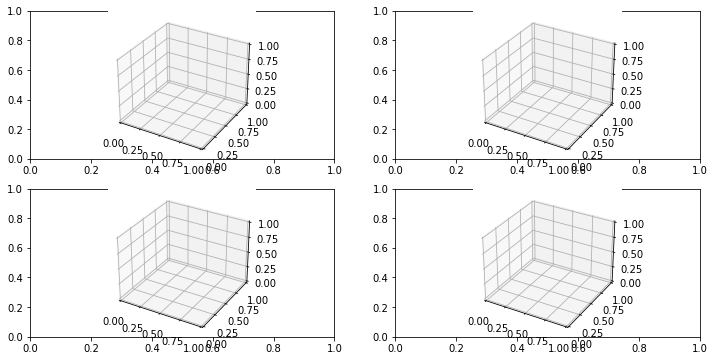

In [6]:
torch.manual_seed(0)

model.to_cpu(model.net_k,model.net_u, model=True)

##test data
with open(f'test_data_2d_{lc}lc_{sigma}sigma_origin.pkl', 'rb') as ff:
    test_data = pickle.load(ff)
for key in test_data.keys():
    test_data[key] = to_torch(test_data[key])
    
x_val = test_data['x']
k_mean_ref, k_std_ref = test_data['k_mean'], test_data['k_std']
u_mean_ref, u_std_ref = test_data['u_mean'], test_data['u_std']


fig_QoI, axes_QoI = plt.subplots(2,2, figsize=(12,6))

for i in range(2):
    for j in range(2):
        axes_QoI[i,j] = fig_QoI.add_subplot(2, 2, 2*i+j+1, projection='3d')
with torch.no_grad():
    _, k_mean, k_std = model.predict_k_FC(x_val, n_tile_val)
    _, u_mean, u_std = model.predict_u_FC(x_val, n_tile_val)

er_mean_k = torch.norm(k_mean-k_mean_ref)/torch.norm(k_mean_ref)
er_std_k = torch.norm(k_std-k_std_ref)/torch.norm(k_std_ref)
er_mean_u = torch.norm(u_mean-u_mean_ref)/torch.norm(u_mean_ref)
er_std_u = torch.norm(u_std-u_std_ref)/torch.norm(u_std_ref)
print(f'model error: {er_mean_k:.3e}, {er_std_k:.3e}, {er_mean_u:.3e}, {er_std_u:.3e}')


axes_QoI[0,0].plot_trisurf(x_val[0], x_val[1], k_mean, linewidth=0.2, antialiased=True, label='GAN')
axes_QoI[0,1].plot_trisurf(x_val[0], x_val[1], k_std, linewidth=0.2, antialiased=True, label='GAN')
axes_QoI[1,0].plot_trisurf(x_val[0], x_val[1], u_mean, linewidth=0.2, antialiased=True, label='GAN')
axes_QoI[1,1].plot_trisurf(x_val[0], x_val[1], u_std, linewidth=0.2, antialiased=True, label='GAN')


#-------------------------------------------------------------------------------
axes_QoI[0,0].plot_trisurf(x_val[0], x_val[1], k_mean_ref, linewidth=0.2, antialiased=True, label='reference')
axes_QoI[0,1].plot_trisurf(x_val[0], x_val[1], k_std_ref, linewidth=0.2, antialiased=True, label='reference')
axes_QoI[1,0].plot_trisurf(x_val[0], x_val[1], u_mean_ref, linewidth=0.2, antialiased=True, label='reference')
axes_QoI[1,1].plot_trisurf(x_val[0], x_val[1], u_std_ref, linewidth=0.2, antialiased=True, label='reference')

fig_QoI.show()

In [ ]:
fig_QoI, axes_QoI = plt.subplots(2, 2, figsize=(12, 6))

start = 101*25
end = 101*26
axes_QoI[0,0].plot(x_val[1,start:end],k_mean[start:end], label='GAN')
axes_QoI[0,1].plot(x_val[1,start:end],k_std[start:end], label='GAN')
axes_QoI[1,0].plot(x_val[1,start:end],u_mean[start:end], label='GAN')
axes_QoI[1,1].plot(x_val[1,start:end],u_std[start:end], label='GAN')

er_mean_k = torch.norm(k_mean-k_mean_ref)/torch.norm(k_mean_ref)
er_std_k = torch.norm(k_std-k_std_ref)/torch.norm(k_std_ref)
er_mean_u = torch.norm(u_mean-u_mean_ref)/torch.norm(u_mean_ref)
er_std_u = torch.norm(u_std-u_std_ref)/torch.norm(u_std_ref)
print(f'SPDE FC: {er_mean_k:.3e}, {er_std_k:.3e}, {er_mean_u:.3e}, {er_std_u:.3e}')


#-------------------------------------------------------------------------------
axes_QoI[0,0].plot(x_val[1,start:end],k_mean_ref[start:end], label='reference')
axes_QoI[0,1].plot(x_val[1,start:end],k_std_ref[start:end], label='reference')
axes_QoI[1,0].plot(x_val[1,start:end],u_mean_ref[start:end], label='reference')
axes_QoI[1,1].plot(x_val[1,start:end],u_std_ref[start:end], label='reference')

axes_QoI[0].set_title('mean at x=-0.5')
axes_QoI[1].set_title('standard deviation at x=-0.5')
axes_QoI[0].set_xlabel('y')
axes_QoI[1].set_xlabel('y')
# fig_QoI.savefig('SPDE_2d_QoI_x=-0.5.pdf')
fig_QoI.show()

In [ ]:
#version2_2 = [*, 128, 128, *]